In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np

# Загрузка датасета в формате FASTA

In [2]:
!pip install biopython

In [8]:
from Bio import SeqIO

# Зададим путь к данным
file_path = "ictv_reference_no_inserted.fa"

# Распарсим файл в формате FASTA
records = {}

for record in SeqIO.parse(file_path, "fasta"):
    record_id = record.id.split('.')[0]

    if record_id not in records:
        records[record_id] = str(record.seq)
    else:
        print("MISTAKE")

In [9]:
# Проанализируем минимальную и максимальную длины
max_lengths = []

for record in records.values():
    max_lengths.append(len(record))

min(max_lengths), max(max_lengths)

(166, 1991922)

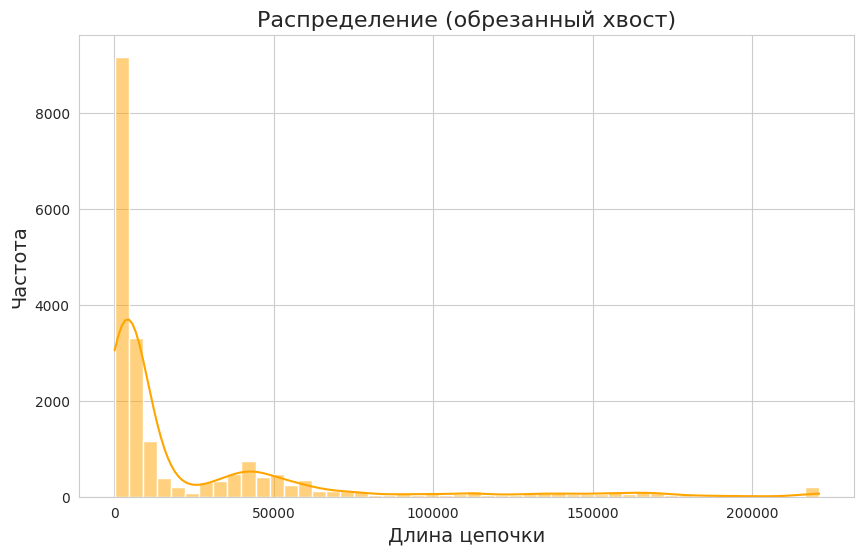

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Находим 99-й перцентиль
threshold = np.percentile(max_lengths, 99)

# Усечение данных по трешхолду, вычисленному на основе перцентиля
trimmed_lengths = [x if x <= threshold else threshold for x in max_lengths]

# Построим график
sns.set_style('whitegrid')
plt.figure(figsize = (10, 6))
sns.histplot(trimmed_lengths, bins = 50, kde = True, color = 'orange')
plt.title('Распределение (обрезанный хвост)', fontsize = 16)
plt.xlabel('Длина цепочки', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()


In [11]:
record_items = records.items()
record_ids = list(map(lambda x: x[0], record_items))
record_values = list(map(lambda x: x[1], record_items))

# Загрузка датасета-таблицы с характеристиками вирусов

In [12]:
import pandas as pd

# Укажем путь к файлу
file_path = "VMR_MSL39_v2.xlsx"

# Читаем второй лист (индексация листов начинается с 0)
virus_data = pd.read_excel(file_path, sheet_name = 1)

# Покажем первые несколько строк
print(virus_data.head())

   Isolate ID  Species Sort  Isolate Sort      Realm  Subrealm      Kingdom  \
0     1000002             1             1  Adnaviria       NaN  Zilligvirae   
1     1000001             2             1  Adnaviria       NaN  Zilligvirae   
2     1000003             3             1  Adnaviria       NaN  Zilligvirae   
3     1000008             4             1  Adnaviria       NaN  Zilligvirae   
4     1000005             5             1  Adnaviria       NaN  Zilligvirae   

   Subkingdom         Phylum Subphylum          Class  ...  \
0         NaN  Taleaviricota       NaN  Tokiviricetes  ...   
1         NaN  Taleaviricota       NaN  Tokiviricetes  ...   
2         NaN  Taleaviricota       NaN  Tokiviricetes  ...   
3         NaN  Taleaviricota       NaN  Tokiviricetes  ...   
4         NaN  Taleaviricota       NaN  Tokiviricetes  ...   

                             Virus name(s) Virus name abbreviation(s)  \
0           Sulfolobus filamentous virus 1                       SFV1   
1   Su

In [13]:
# Посмотрим на имеющиеся колонки
virus_data.columns

Index(['Isolate ID', 'Species Sort', 'Isolate Sort', 'Realm', 'Subrealm',
       'Kingdom', 'Subkingdom', 'Phylum', 'Subphylum', 'Class', 'Subclass',
       'Order', 'Suborder', 'Family', 'Subfamily', 'Genus', 'Subgenus',
       'Species', 'Exemplar or additional isolate', 'Virus name(s)',
       'Virus name abbreviation(s)', 'Virus isolate designation',
       'Virus GENBANK accession', 'Virus REFSEQ accession',
       'Virus REFSEQ NCBI taxid', 'Genome coverage', 'Genome composition',
       'Host source', 'Accessions Link'],
      dtype='object')

In [14]:
# У части вирусов несколько айдишников, указывающих на цепочки, развернем их в разные строки
virus_data['Virus GENBANK accession'] = virus_data['Virus GENBANK accession'].str.split('; ')
virus_data = virus_data.explode('Virus GENBANK accession', ignore_index = True)

# Сравнительный анализ двух кластеров по фичам

## Препроцессинг эмбеддингов

In [10]:
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np

class SequenceDataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length):
        """
        Инициализация датасета.

        :param sequences: Список последовательностей.
        :param tokenizer: Токенизатор (например, из Hugging Face Transformers).
        :param max_length: Максимальная длина последовательности после токенизации.
        """
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Получение одного элемента датасета.

        :param idx: Индекс последовательности.
        :return: Словарь с `input_ids` и `attention_mask`.
        """
        sequence = self.sequences[idx]
        
        # Токенизация без усечения
        encoding = self.tokenizer.encode_plus(
            sequence,
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt',
            padding='max_length',  # Паддинг до max_length
            max_length=self.max_length,
            truncation=False  # Отключаем автоматическое усечение
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Удаляем лишнее измерение
        attention_mask = encoding['attention_mask'].squeeze(0)

        # Если длина последовательности превышает max_length, выбираем случайный кусочек
        if input_ids.size(0) > self.max_length:
            # Вычисляем допустимый диапазон начала окна
            max_start = input_ids.size(0) - self.max_length
            start_idx = random.randint(0, max_start)
            input_ids = input_ids[start_idx:start_idx + self.max_length]
            attention_mask = attention_mask[start_idx:start_idx + self.max_length]
        # Если длина меньше max_length, паддинг уже применен

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

In [11]:
from transformers import AutoTokenizer, AutoModel
from transformers.models.bert.configuration_bert import BertConfig

config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config).half().to("cuda")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

max_length = tokenizer.model_max_length

/home/ledneva/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ledneva/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
max_length = 512

In [13]:
# Параметры
batch_size = 4  # Настройте в соответствии с памятью GPU

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание датасета и загрузчика данных
dataset = SequenceDataset(record_values, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Перенос модели на устройство и установка режима оценки
model.to(device)
model.eval()

embeds = []

# Отключение вычисления градиентов
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Processing Batches"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Использование смешанной точности (опционально)
        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_attention_mask=attention_mask,
                output_hidden_states=True
            )

        # Получение последнего скрытого слоя
        embeddings = outputs[0]  # Форма: (batch_size, seq_length, hidden_size)

        attention_mask_expanded = attention_mask.unsqueeze(-1)  # Форма: (batch_size, seq_length, 1)
        sum_embeddings = torch.sum(embeddings * attention_mask_expanded, dim=1)  # Форма: (batch_size, hidden_size)
        sum_mask = torch.clamp(attention_mask_expanded.sum(dim=1), min=1e-9)  # Избегаем деления на ноль
        mean_embeddings = sum_embeddings / sum_mask  # Форма: (batch_size, hidden_size)

        # Перенос на CPU и преобразование в NumPy
        embeds.append(mean_embeddings.cpu().numpy())

# Объединение всех эмбеддингов в один массив NumPy
embeds = np.vstack(embeds)

# Опционально, очистка кэша CUDA после обработки
torch.cuda.empty_cache()

/tmp/ipykernel_564031/2052114748.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Processing Batches: 100%|████████████████████████████████████████████| 4940/4940 [12:31<00:00,  6.57it/s]


In [14]:
import numpy as np
np.save("embeds_dnabert-2-117m-v2.npy", embeds)

In [10]:
import numpy as np

embeds = np.load("embeds_dnabert-2-117m-v2.npy").reshape((19758, 768))
np.array(embeds).shape

(19758, 768)

In [11]:
embeds_dict = dict(zip(record_ids, embeds))

In [12]:
embedding_matrix = [embeds_dict.get(id_, None) for id_ in virus_data['Virus GENBANK accession']]

In [13]:
virus_data_dnabert_2_117m = virus_data.copy()
virus_data_dnabert_2_117m['embeds'] = embedding_matrix
virus_data_dnabert_2_117m = virus_data_dnabert_2_117m.dropna(subset = ['embeds'])

## Анализ кластеризации

/home/ledneva/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


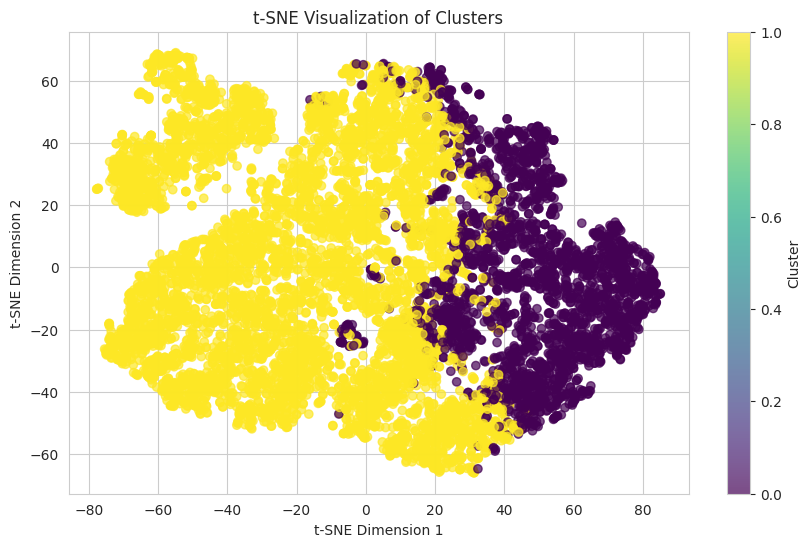

In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind
from tqdm import tqdm

# Шаг 1: Очистка данных
columns_to_use = [
    'Realm', 'Kingdom', 'Phylum', 'Class', 'Genome coverage', 
    'Genome composition', 'Host source', 'Order', 'Family', 
    'Genus', 'Species', 'Exemplar or additional isolate'
]

# Убираем строки с NaN в текстовых колонках и embeds
virus_data_cleaned = virus_data_dnabert_2_117m.dropna(subset=columns_to_use + ['embeds']).copy()

# Шаг 2: Кластеризация на основе embeds
X = np.vstack(virus_data_cleaned['embeds'])

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

# Шаг 5: Визуализация кластеров с t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [43]:
from scipy.stats import mannwhitneyu

# Функция для альтернативного теста Манна-Уитни
def compare_clusters_mannwhitney(one_hot_data, cluster_labels):
    results = []
    for column in tqdm(one_hot_data.columns):
        cluster_0 = one_hot_data[cluster_labels == 0][column]
        cluster_1 = one_hot_data[cluster_labels == 1][column]
        try:
            u_stat, p_val = mannwhitneyu(cluster_0, cluster_1, alternative='two-sided')
            results.append((column, u_stat, p_val))
        except ValueError:  # Возможные ошибки из-за недостатка данных
            results.append((column, None, None))
    results_df = pd.DataFrame(results, columns=['Feature', 'U-statistic', 'P-value'])
    return results_df.sort_values(by='P-value')

# Альтернативный анализ
mannwhitney_results = compare_clusters_mannwhitney(one_hot_features, clusters)

# Сортировка и просмотр результатов
print("Наиболее значимые признаки по тесту Манна-Уитни:")
print(mannwhitney_results.head(20))

In [ ]:
mannwhitney_results.to_excel("comparison_results.xlsx")

In [44]:
comparison_results = pd.read_excel("comparison_results.xlsx", index_col = 0)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Установим пороговое значение для P-value
p_value_threshold = 0.1

# Фильтруем значимые признаки
significant_features = comparison_results[
    comparison_results['P-value'] < p_value_threshold
].sort_values(by='P-value')

# Выводим значимых признаков
print("Значимые признаки:")
print(significant_features)

# Визуализация значимых признаков
def plot_significant_features(data, features, cluster_labels, max_features=5):
    for feature in features[:max_features]:
        plt.figure(figsize=(8, 5))
        data['cluster'] = cluster_labels  # Добавляем метки кластеров в данные
        boxplot_data = data[[feature, 'cluster']]
        boxplot_data.boxplot(by='cluster', column=feature, grid=False)
        plt.title(f'Распределение фичи: {feature}')
        plt.suptitle('')  # Убираем общий заголовок
        plt.xlabel('Кластеры')
        plt.ylabel('Значение')
        plt.show()

# Получение первых 5 значимых признаков
# top_significant_features = significant_features['Feature'].head(5).tolist()

# Визуализация
# plot_significant_features(
#     one_hot_features, top_significant_features, clusters
# )

Значимые признаки:
                                     Feature  U-statistic        P-value
169                       Order_Timlovirales   10543860.0  1.078499e-212
349                     Family_Steitzviridae   10493641.0  7.270654e-208
48                       Class_Leviviricetes   10796788.0  1.367545e-165
68    Genome coverage_Coding-complete genome   11000706.5  2.561604e-162
9                      Kingdom_Orthornavirae   10862726.0  1.256463e-160
...                                      ...          ...            ...
6765         Species_Mastadenovirus exoticum    8384951.0   9.366109e-02
1572                      Genus_Oxychlovirus    8411452.0   9.430081e-02
87                 Host source_invertebrates    8314267.0   9.530242e-02
1643                       Genus_Pihngevirus    8406341.0   9.633678e-02
1316                      Genus_Lohngkovirus    8382977.5   9.847785e-02

[536 rows x 3 columns]
